In [47]:
import os
import gc
import joblib
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections.abc import Iterable
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from typing import Union
from tqdm import tqdm

warnings.filterwarnings("ignore")
%matplotlib inline


In [2]:
gc.collect()
data = pd.read_pickle('../data/processed/fe2_data.pkl')

In [138]:
sales = pd.read_pickle('../data/processed/item_sales.pkl') 
price = pd.read_pickle('../data/processed/item_prices.pkl') 
cal = pd.read_pickle('../data/processed/daily_calendar_with_events.pkl')

In [59]:
d_id = dict(zip(sales.id.cat.codes, sales.id))
d_item_id = dict(zip(sales.item.cat.codes, sales.item))
d_department_id = dict(zip(sales.department.cat.codes, sales.department))
d_category_id = dict(zip(sales.category.cat.codes, sales.category))
d_store_id = dict(zip(sales.store_code.cat.codes, sales.store_code))
d_region_id = dict(zip(sales.region.cat.codes, sales.region))

In [121]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58327370 entries, 0 to 58327369
Data columns (total 27 columns):
 #   Column           Dtype  
---  ------           -----  
 0   id               int16  
 1   item             int16  
 2   category         int8   
 3   department       int8   
 4   store_code       int8   
 5   region           int8   
 6   d                int16  
 7   sales            int16  
 8   weekday_int      int8   
 9   event            int8   
 10  year             int64  
 11  month            int64  
 12  day              int64  
 13  week             object 
 14  yearweek         object 
 15  sell_price       float32
 16  lag_1            float16
 17  lag_2            float16
 18  lag_3            float16
 19  lag_5            float16
 20  lag_7            float16
 21  lag_14           float16
 22  lag_21           float16
 23  lag_28           float16
 24  rolling_mean_10  float64
 25  rolling_mean_20  float64
 26  rolling_mean_30  float64
dtypes: float16

In [124]:
data['event'].unique()

array([1, 4, 3, 5, 2, 0], dtype=int8)

In [5]:
data['item'] = data['item'].astype('category')
data['category'] = data['category'].astype('category')
data['store_code'] = data['store_code'].astype('category')

In [6]:
cols = data.dtypes.index.tolist()
d_types = data.dtypes.values.tolist()

for i,type in enumerate(d_types):
    if type.name == 'category':
        data[cols[i]] = data[cols[i]].cat.codes

In [127]:
data.head()

,id,item,category,department,store_code,region,d,sales,weekday_int,event,...,lag_2,lag_3,lag_5,lag_7,lag_14,lag_21,lag_28,rolling_mean_10,rolling_mean_20,rolling_mean_30
0,3,0,0,0,3,1,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,13,1,0,0,3,1,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,23,2,0,0,3,1,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,33,3,0,0,3,1,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,43,4,0,0,3,1,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
print(1913*0.6)  # <=1147 treino 60%
print((1913-1147)/2) # 383 validação 20%
#383 teste 20%

1147.8
383.0


In [116]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58327370 entries, 0 to 58327369
Data columns (total 27 columns):
 #   Column           Dtype  
---  ------           -----  
 0   id               int16  
 1   item             int16  
 2   category         int8   
 3   department       int8   
 4   store_code       int8   
 5   region           int8   
 6   d                int16  
 7   sales            int16  
 8   weekday_int      int8   
 9   event            int8   
 10  year             int64  
 11  month            int64  
 12  day              int64  
 13  week             int16  
 14  yearweek         int32  
 15  sell_price       float32
 16  lag_1            float16
 17  lag_2            float16
 18  lag_3            float16
 19  lag_5            float16
 20  lag_7            float16
 21  lag_14           float16
 22  lag_21           float16
 23  lag_28           float16
 24  rolling_mean_10  float64
 25  rolling_mean_20  float64
 26  rolling_mean_30  float64
dtypes: float16

### XGBRegressor

In [7]:
#distribuição dos dados

X_train = data[data['d']<=1147]
X_val = data[(data['d']>1147) & (data['d']<=1530)]
X_test = data[(data['d']>1530)]

y_train = X_train['sales']
y_val = X_val['sales']
y_test = X_test['sales']

X_train.drop(['id', 'd','sales', 'yearweek','week','day'],axis = 1,inplace = True)
X_val.drop(['id', 'd','sales', 'yearweek','week','day'],axis = 1,inplace = True)
X_test.drop(['id', 'd','sales', 'yearweek','week','day'],axis = 1,inplace = True)

print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)
print(X_test.shape)

(35002520, 21) (35002520,)
(11677670, 21) (11677670,)
(11647180, 21)


In [18]:
del data

In [129]:
X_train.head()

,item,category,department,store_code,region,weekday_int,event,year,month,sell_price,...,lag_2,lag_3,lag_5,lag_7,lag_14,lag_21,lag_28,rolling_mean_10,rolling_mean_20,rolling_mean_30
0,0,0,0,3,1,1,1,2011,1,11.010936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0,0,3,1,1,1,2011,1,5.281250,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0,0,3,1,1,1,2011,1,3.949219,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,0,0,3,1,1,1,2011,1,6.019237,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0,0,3,1,1,1,2011,1,3.914190,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
class WRMSSEEvaluator(object):

    def __init__(self, train_df: pd.DataFrame, valid_df: pd.DataFrame, calendar: pd.DataFrame, prices: pd.DataFrame):
        train_y = train_df.loc[:, train_df.columns.str.startswith('d_')]
        train_target_columns = train_y.columns.tolist()
        weight_columns = train_y.iloc[:, -383:].columns.tolist()

        train_df['all_id'] = 0  # for lv1 aggregation

        id_columns = train_df.loc[:, ~train_df.columns.str.startswith('d_')].columns.tolist()
        valid_target_columns = valid_df.loc[:, valid_df.columns.str.startswith('d_')].columns.tolist()

        if not all([c in valid_df.columns for c in id_columns]):
            valid_df = pd.concat([train_df[id_columns], valid_df], axis=1, sort=False)

        self.train_df = train_df
        self.valid_df = valid_df
        self.calendar = calendar
        self.prices = prices

        self.weight_columns = weight_columns
        self.id_columns = id_columns
        self.valid_target_columns = valid_target_columns

        weight_df = self.get_weight_df()

        self.group_ids = (
            'all_id',
            'region',
            'store_code',
            'category',
            'department',
            ['region', 'category'],
            ['region', 'department'],
            ['store_code', 'category'],
            ['store_code', 'department'],
            'item',
            ['item', 'region'],
            ['item', 'store_code']
        )

        for i, group_id in enumerate(tqdm(self.group_ids)):
            train_y = train_df.groupby(group_id)[train_target_columns].sum()
            scale = []
            for _, row in train_y.iterrows():
                series = row.values[np.argmax(row.values != 0):]
                scale.append(((series[1:] - series[:-1]) ** 2).mean())
            setattr(self, f'lv{i + 1}_scale', np.array(scale))
            setattr(self, f'lv{i + 1}_train_df', train_y)
            setattr(self, f'lv{i + 1}_valid_df', valid_df.groupby(group_id)[valid_target_columns].sum())

            lv_weight = weight_df.groupby(group_id)[weight_columns].sum().sum(axis=1)
            setattr(self, f'lv{i + 1}_weight', lv_weight / lv_weight.sum())

    def get_weight_df(self) -> pd.DataFrame:
        day_to_week = self.calendar.set_index('d')['yearweek'].to_dict()
        weight_df = self.train_df[['item', 'store_code'] + self.weight_columns].set_index(['item', 'store_code'])
        weight_df = weight_df.stack().reset_index().rename(columns={'level_2': 'd', 0: 'value'})
        weight_df['yearweek'] = weight_df['d'].map(day_to_week)

        weight_df = weight_df.merge(self.prices, how='left', on=['item', 'store_code', 'yearweek'])
        weight_df['value'] = weight_df['value'] * weight_df['sell_price']
        weight_df = weight_df.set_index(['item', 'store_code', 'd']).unstack(level=2)['value']
        weight_df = weight_df.loc[zip(self.train_df.item, self.train_df.store_code), :].reset_index(drop=True)
        weight_df = pd.concat([self.train_df[self.id_columns], weight_df], axis=1, sort=False)
        return weight_df

    def rmsse(self, valid_preds: pd.DataFrame, lv: int) -> pd.Series:
        valid_y = getattr(self, f'lv{lv}_valid_df')
        score = ((valid_y - valid_preds) ** 2).mean(axis=1)
        scale = getattr(self, f'lv{lv}_scale')
        return (score / scale).map(np.sqrt)

    def score(self, valid_preds: Union[pd.DataFrame, np.ndarray]) -> float:
        assert self.valid_df[self.valid_target_columns].shape == valid_preds.shape

        if isinstance(valid_preds, np.ndarray):
            valid_preds = pd.DataFrame(valid_preds, columns=self.valid_target_columns)

        valid_preds = pd.concat([self.valid_df[self.id_columns], valid_preds], axis=1, sort=False)

        all_scores = []
        for i, group_id in enumerate(self.group_ids):
            lv_scores = self.rmsse(valid_preds.groupby(group_id)[self.valid_target_columns].sum(), i + 1)
            weight = getattr(self, f'lv{i + 1}_weight')
            lv_scores = pd.concat([weight, lv_scores], axis=1, sort=False).prod(axis=1)
            print(lv_scores.sum())
            all_scores.append(lv_scores.sum())

        return np.mean(all_scores)

    

In [131]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35002520 entries, 0 to 35002519
Data columns (total 21 columns):
 #   Column           Dtype  
---  ------           -----  
 0   item             int16  
 1   category         int8   
 2   department       int8   
 3   store_code       int8   
 4   region           int8   
 5   weekday_int      int8   
 6   event            int8   
 7   year             int64  
 8   month            int64  
 9   sell_price       float32
 10  lag_1            float16
 11  lag_2            float16
 12  lag_3            float16
 13  lag_5            float16
 14  lag_7            float16
 15  lag_14           float16
 16  lag_21           float16
 17  lag_28           float16
 18  rolling_mean_10  float64
 19  rolling_mean_20  float64
 20  rolling_mean_30  float64
dtypes: float16(8), float32(1), float64(3), int16(1), int64(2), int8(6)
memory usage: 2.5 GB


In [9]:
#Hyeperparameter tuning
#Manually tuning learning_rate and max_depth

lr = [0.01, 0.05, 0.1]
md = [3, 5, 7]

for i in lr:
    for j in md:
        xgb_ht = XGBRegressor(objective = 'reg:tweedie', learning_rate = i, max_depth = j, subsample = 0.7, 
                              colsample_bytree = 0.7, n_estimators = 100) 
        
        xgb_ht.fit(X_train,y_train)
        y_pred = xgb_ht.predict(X_test)
        rmse = mean_squared_error(y_test,y_pred) ** 0.5
        print("*" * 50)
        print(f"For learning_rate = {i} and max_depth = {j}, the rmse = {rmse}")
        print("*" * 50)

**************************************************
For learning_rate = 0.01 and max_depth = 3, the rmse = 3.3521463379155723
**************************************************
**************************************************
For learning_rate = 0.01 and max_depth = 5, the rmse = 3.341230352239072
**************************************************
**************************************************
For learning_rate = 0.01 and max_depth = 7, the rmse = 3.3383090235230837
**************************************************
**************************************************
For learning_rate = 0.05 and max_depth = 3, the rmse = 2.0046391327420383
**************************************************
**************************************************
For learning_rate = 0.05 and max_depth = 5, the rmse = 1.9085042788083066
**************************************************
**************************************************
For learning_rate = 0.05 and max_depth = 7, the rmse = 1.8592736993971

In [10]:
xgb = XGBRegressor(objective = 'reg:tweedie', learning_rate = 0.1, max_depth = 7, subsample = 0.7, 
                   colsample_bytree = 0.7, n_estimators = 100)

xgb.fit(X_train,y_train, eval_set=[(X_val,y_val)], eval_metric='rmse', verbose=10)

[0]	validation_0-rmse:3.65861
[10]	validation_0-rmse:3.28459
[20]	validation_0-rmse:2.64250
[30]	validation_0-rmse:2.10562
[40]	validation_0-rmse:1.90392
[50]	validation_0-rmse:1.86309
[60]	validation_0-rmse:1.84919
[70]	validation_0-rmse:1.84143
[80]	validation_0-rmse:1.83388
[90]	validation_0-rmse:1.82887
[99]	validation_0-rmse:1.82513


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=7, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, objective='reg:tweedie', predictor='auto', ...)

In [11]:
import pickle
pickle.dump(xgb,open('../models/xgb.pkl','wb'))

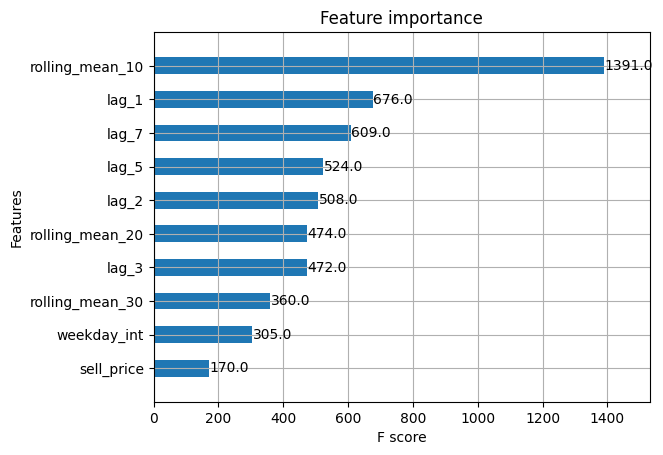

In [12]:
from xgboost import plot_importance

plot_importance(xgb, max_num_features = 10, height = 0.5)
plt.show()

In [19]:
print(X_val.shape)
print(X_test.shape)

(11677670, 21)
(11647180, 21)


In [40]:
pred_val_array  = xgb.predict(X_val)
pred_test_array  = xgb.predict(X_test)

pred_val_array = np.reshape(pred_val_array, (-1, X_val.shape[0]),order = 'F')
pred_test_array = np.reshape(pred_test_array, (-1, X_test.shape[0]),order = 'F')

In [42]:
price['yearweek']=price['yearweek'].astype('Int64').astype('object')

In [43]:
price.head()

,item,category,store_code,yearweek,sell_price
0,ACCESORIES_1_001,ACCESORIES,NYC_1,201328,12.742188
1,ACCESORIES_1_001,ACCESORIES,NYC_1,201329,12.742188
2,ACCESORIES_1_001,ACCESORIES,NYC_1,201330,10.984375
3,ACCESORIES_1_001,ACCESORIES,NYC_1,201331,10.984375
4,ACCESORIES_1_001,ACCESORIES,NYC_1,201332,10.984375


In [44]:
cal['date'] = pd.to_datetime(cal['date'])
cal['year'] = cal['date'].dt.year
cal['week'] = cal['date'].dt.isocalendar().week.apply(str)
cal['week'] = cal['week'].apply(lambda x: x.zfill(2))
cal['yearweek'] = cal['year'].apply(str) + cal['week']

In [45]:
cal = cal.drop(['year','week'], axis=1)

In [46]:
cal.head()

,date,weekday,weekday_int,d,event,yearweek
0,2011-01-29,Saturday,1,d_1,NaN,201104
1,2011-01-30,Sunday,2,d_2,NaN,201104
2,2011-01-31,Monday,3,d_3,NaN,201105
3,2011-02-01,Tuesday,4,d_4,NaN,201105
4,2011-02-02,Wednesday,5,d_5,NaN,201105


In [36]:
d_cols = [d for d in sales.columns if 'd_' in d][-383:]
preds_val = pd.DataFrame(pred_val_array,columns = d_cols)
train_df = sales.iloc[:,:-383]
val_df = sales.iloc[:,-383:]
evaluator = WRMSSEEvaluator(train_df, val_df, cal, price)
score = evaluator.score(preds_val)
print("WRMSSE score of validation data [for days 1147-1530]:",score)

100%|██████████| 12/12 [00:09<00:00,  1.33it/s]


AssertionError: 

In [76]:
score = evaluator.score(preds_val)

,d_1531,d_1532,d_1533,d_1534,d_1535,d_1536,d_1537,d_1538,d_1539,d_1540,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
30488,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,3,1,3
30489,1,2,2,4,3,0,3,0,4,0,...,0,0,0,0,0,0,0,0,0,0


### LGBMRegressor

In [50]:
data['week'] = data['week'].astype(np.int16)
data['yearweek'] = data['yearweek'].astype(np.int32)

In [81]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58327370 entries, 0 to 58327369
Data columns (total 27 columns):
 #   Column           Dtype  
---  ------           -----  
 0   id               int16  
 1   item             int16  
 2   category         int8   
 3   department       int8   
 4   store_code       int8   
 5   region           int8   
 6   d                int16  
 7   sales            int16  
 8   weekday_int      int8   
 9   event            int8   
 10  year             int64  
 11  month            int64  
 12  day              int64  
 13  week             int16  
 14  yearweek         int32  
 15  sell_price       float32
 16  lag_1            float16
 17  lag_2            float16
 18  lag_3            float16
 19  lag_5            float16
 20  lag_7            float16
 21  lag_14           float16
 22  lag_21           float16
 23  lag_28           float16
 24  rolling_mean_10  float64
 25  rolling_mean_20  float64
 26  rolling_mean_30  float64
dtypes: float16

In [77]:
#distribuição dos dados
valid = data[(data['d']>1147) & (data['d']<=1530)][['id','d','sales']]
test = data[data['d']>1530][['id','d','sales']]
eval_preds = test['sales']
valid_preds = valid['sales']

In [88]:
#pegandos os store codes
stores = sales.store_code.cat.codes.unique().tolist()
for store in stores:
    df = data[data['store_code']==store]
    
    #dividindo os dados
    columnsTrain = [i for i in df.columns if (i.startswith('lag_') == False) & (i.startswith('rolling_mean_') == False) & (i.startswith('sales') == False)]
    X_train, y_train = df[df['d']<=1147][columnsTrain], df[df['d']<=1147]['sales']
    X_valid, y_valid = df[(df['d']>1147) & (df['d']<=1530)][columnsTrain], df[(df['d']>1147) & (df['d']<=1530)]['sales']
    X_test = df[df['d']>1530][columnsTrain]
    
    #treino e validação
    model = LGBMRegressor(
        n_estimators=1000,
        learning_rate=0.3,
        subsample=0.8,
        colsample_bytree=0.8,
        max_depth=8,
        num_leaves=50,
        min_child_weight=300
    )
    print('*****Prediction for Store: {}*****'.format(d_store_id[store]))
    model.fit(X_train, y_train, eval_set=[(X_train,y_train),(X_valid,y_valid)],
             eval_metric='rmse', verbose=20, early_stopping_rounds=20)
    valid_preds[X_valid.index] = model.predict(X_valid)
    eval_preds[X_test.index] = model.predict(X_test)
    filename = '../models/model'+str(d_store_id[store])+'.pkl'
    # salvando o modelo
    joblib.dump(model, filename)
    del model, X_train, y_train, X_valid, y_valid
    gc.collect()

*****Prediction for Store: NYC_1*****
[20]	training's rmse: 3.41707	training's l2: 11.6763	valid_1's rmse: 3.32358	valid_1's l2: 11.0462
[40]	training's rmse: 3.24562	training's l2: 10.5341	valid_1's rmse: 3.21419	valid_1's l2: 10.331
[60]	training's rmse: 3.15637	training's l2: 9.96266	valid_1's rmse: 3.17067	valid_1's l2: 10.0531
[80]	training's rmse: 3.10633	training's l2: 9.64927	valid_1's rmse: 3.1389	valid_1's l2: 9.85266
[100]	training's rmse: 3.06375	training's l2: 9.38657	valid_1's rmse: 3.11836	valid_1's l2: 9.72417
[120]	training's rmse: 3.02994	training's l2: 9.18055	valid_1's rmse: 3.09338	valid_1's l2: 9.56898
[140]	training's rmse: 3.0102	training's l2: 9.06128	valid_1's rmse: 3.08955	valid_1's l2: 9.54535
[160]	training's rmse: 2.99273	training's l2: 8.95642	valid_1's rmse: 3.08271	valid_1's l2: 9.50312
[180]	training's rmse: 2.97503	training's l2: 8.85081	valid_1's rmse: 3.07892	valid_1's l2: 9.47974
[200]	training's rmse: 2.96229	training's l2: 8.77517	valid_1's rmse:

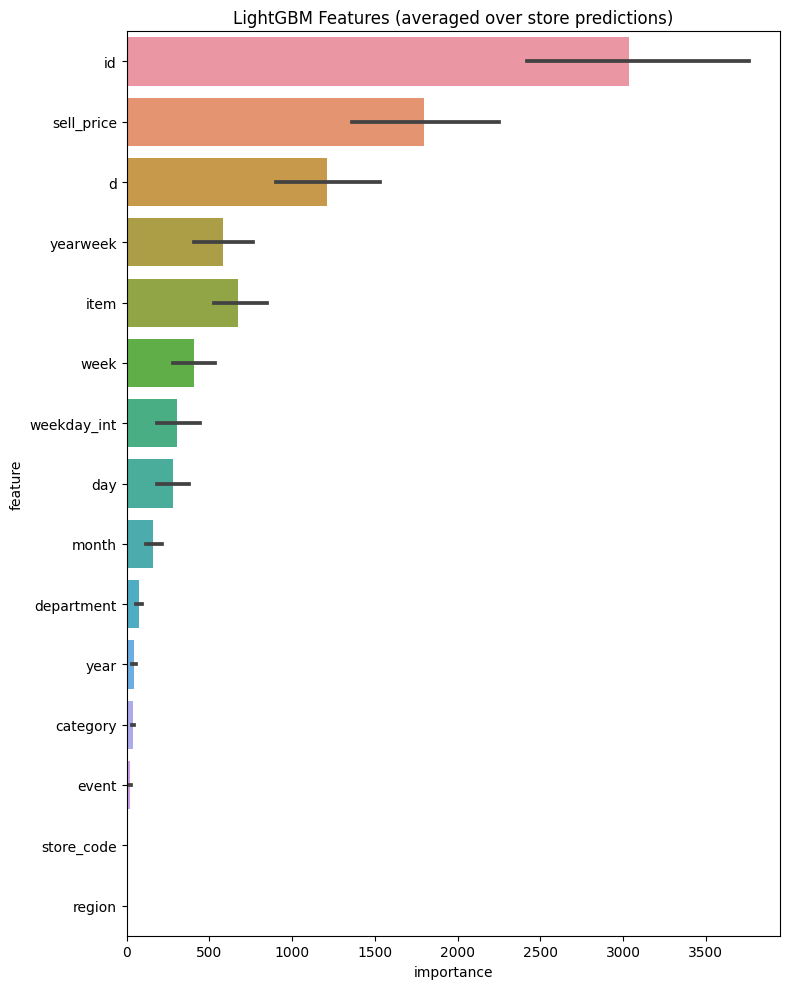

In [90]:
feature_importance_df = pd.DataFrame()
features = columnsTrain
for filename in os.listdir('../models/'):
    if 'model' in filename:
        #carregando o modelo
        model = joblib.load(f'../models/{filename}')
        store_importance_df = pd.DataFrame()
        store_importance_df["feature"] = features
        store_importance_df["importance"] = model.feature_importances_
        store_importance_df["store"] = filename[5:9]
        feature_importance_df = pd.concat([feature_importance_df, store_importance_df], axis=0)
    
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:20].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (averaged over store predictions)')
    plt.tight_layout()
    
display_importances(feature_importance_df)

In [125]:
bst = joblib.load('../models/modelNYC_3.pkl')

In [157]:
sales

,id,item,category,department,store,store_code,region,d_1,d_2,d_3,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,ACCESORIES_1_001_NYC_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,ACCESORIES_1_002_NYC_1,ACCESORIES_1_002,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,ACCESORIES_1_003_NYC_1,ACCESORIES_1_003,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,ACCESORIES_1_004_NYC_1,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,ACCESORIES_1_005_NYC_1,ACCESORIES_1_005,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,0,0,0,...,2,1,1,0,1,1,2,2,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,SUPERMARKET_3_823_PHI_3,SUPERMARKET_3_823,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,0,0,2,...,2,0,0,0,0,0,1,0,0,1
30486,SUPERMARKET_3_824_PHI_3,SUPERMARKET_3_824,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,0,0,0,...,0,0,0,0,0,0,0,0,1,0
30487,SUPERMARKET_3_825_PHI_3,SUPERMARKET_3_825,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,0,6,0,...,2,1,0,2,0,1,0,0,1,0
30488,SUPERMARKET_3_826_PHI_3,SUPERMARKET_3_826,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,0,0,0,...,0,0,1,0,0,1,0,3,1,3


In [158]:
# max(price[(price['item'] == 'SUPERMARKET_3_090') & (price['store_code'] == 'NYC_3')]['sell_price'])
# sales[(sales['item'] == 'SUPERMARKET_3_090') & (sales['store_code'] == 'NYC_3')]

,id,item,category,department,store,store_code,region,d_1,d_2,d_3,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
8412,SUPERMARKET_3_090_NYC_3,SUPERMARKET_3_090,SUPERMARKET,SUPERMARKET_3,Tribeca,NYC_3,New York,108,132,102,...,129,160,204,86,100,88,77,141,139,130


In [130]:
#usar para achar os ids a partir dos nomes para poder preencher o dataframe de predição

id = int(list({i for i in d_id if d_id[i]=="SUPERMARKET_3_090_NYC_3"})[0])
item_id = int(list({i for i in d_item_id if d_item_id[i]=="SUPERMARKET_3_090"})[0])
category_id = int(list({i for i in d_category_id if d_category_id[i]=="SUPERMARKET"})[0])
department_id = int(list({i for i in d_department_id if d_department_id[i]=="SUPERMARKET_3"})[0])
store_id = int(list({i for i in d_store_id if d_store_id[i]=="NYC_3"})[0])
region_id = int(list({i for i in d_region_id if d_region_id[i]=="New York"})[0])
price = sales[sales['id'] == 'SUPERMARKET_3_090_NYC_3']

In [147]:
columnsTrain = {'id': pd.Series(dtype='int'), 'item': pd.Series(dtype='int'), 'category': pd.Series(dtype='int'), 'department': pd.Series(dtype='int'), 'store_code': pd.Series(dtype='int'), 'region': pd.Series(dtype='int'), 'd': pd.Series(dtype='int'), 'weekday_int': pd.Series(dtype='int'), 'event': pd.Series(dtype='int'), 'year': pd.Series(dtype='int'), 'month': pd.Series(dtype='int'), 'day': pd.Series(dtype='int'), 'week': pd.Series(dtype='int'), 'yearweek': pd.Series(dtype='int'), 'sell_price': pd.Series(dtype='int')}
teste_ = pd.DataFrame(columns=columnsTrain)

In [152]:
# ['id', 'item', 'category', 'department', 'store_code', 'region', 'd', 'weekday_int', 'event', 'year', 'month', 'day', 'week', 'yearweek', 'sell_price']
teste_.loc[len(teste_.index)] = [id, item_id, category_id, department_id, store_id, region_id, 2, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, 1.919921875]

In [153]:
teste_.head()

,id,item,category,department,store_code,region,d,weekday_int,event,year,month,day,week,yearweek,sell_price
0,23145.0,2314.0,2.0,6.0,5.0,1.0,960.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.919922
1,23145.0,2314.0,2.0,6.0,5.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.919922


In [154]:
# predição
y_pred = bst.predict(teste_)
y_pred

array([49.60392833, 20.97017594])

In [159]:
d_category_id

{0: 'ACCESORIES', 1: 'HOME_&_GARDEN', 2: 'SUPERMARKET'}